# UE1: Calibration Curve
Inside the "linear_regression_[group number].csv" files are datasets of concentrations and corresponding absorption values from a UV/VIS 
determination of protein concentration. Using this dataset, carry out the following steps to establish a calibration: 

1. determine the linear range of the method
2. calculate the calibration curve
3. determine the LOD and LOQ of the calibration

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import importlib
import plotting_util
importlib.reload(plotting_util)

try:
    from cavs_style.style import CAVS_style

    plt.style.use(CAVS_style)
except ImportError:
    pass

%matplotlib inline

## 1. Linear Range

In [3]:
idx, concentration, absorption = np.genfromtxt(
    "linear_regression_2.csv", 
    delimiter=',', 
    unpack=True, 
    skip_header=1   # Omit column names (no numeric -> NaNs)
)
len(idx), len(concentration), len(absorption)

(50, 50, 50)

The data consists of 50 measurements. Let's turn the individual NumPy arrays into a single DataArray for convenience of handling (see the [xarray
.DataArray documentation](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html)).

In [4]:
protein_da = xr.DataArray(
    absorption,                         # Main absorption data (1D array)
    dims=['idx'],                       # Specify indices as the single axes
    coords={
        'idx': idx,                     # Coordinates for 'idx' dimension
        'c': ('idx', concentration)     # The concentration values for each 'idx'
    }
)

# Add attribute to the 'c' coordinate for the axis label
protein_da.coords['c'].attrs['long_name'] = 'c [µg/ml]'

protein_da

<xarray.DataArray (idx: 50)>
array([-7.000e-03, -1.000e-03,  5.000e-03, -3.000e-03, -7.000e-03,
        8.000e-03,  3.000e-03, -0.000e+00,  1.000e-03,  0.000e+00,
       -5.000e-03,  4.800e-02,  1.020e-01,  1.440e-01,  1.940e-01,
        2.380e-01,  2.900e-01,  3.420e-01,  4.110e-01,  4.430e-01,
        4.690e-01,  5.470e-01,  5.850e-01,  6.010e-01,  6.880e-01,
        7.420e-01,  8.170e-01,  8.380e-01,  8.270e-01,  8.600e-01,
        9.470e-01,  1.052e+00,  9.980e-01,  1.094e+00,  1.116e+00,
        1.175e+00,  1.267e+00,  1.158e+00,  1.205e+00,  1.398e+00,
        1.352e+00,  1.303e+00,  1.675e+00,  1.478e+00,  1.350e+00,
        1.606e+00,  1.424e+00,  1.545e+00,  1.803e+00,  1.504e+00])
Coordinates:
  * idx      (idx) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 45.0 46.0 47.0 48.0 49.0
    c        (idx) float64 0.0 0.0 0.0 0.0 ... 3.6e+03 3.7e+03 3.8e+03 3.9e+03

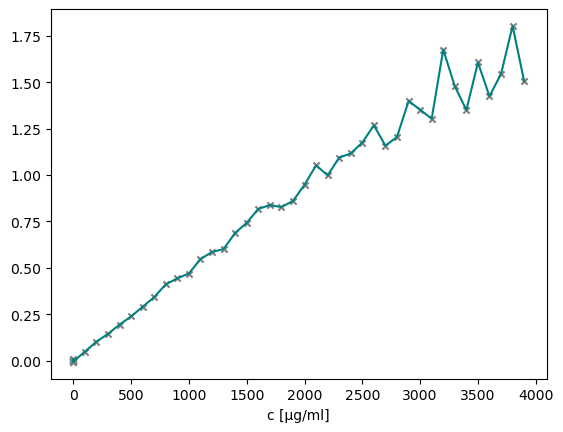

In [70]:
from plotting_util import line_plot_with_marks
line_plot_with_marks(protein_da, x_coord='c', marker='x')

As we we can see from the plot, the **preliminary range** of the data is [0, 4000] µg/ml. This is the range which can be practically measured by 
the measured by the measurement device. 

To establish a calibration we ideally want to work with linear data because it simplifies things a lot. Our data is roughly linear, but there is a 
lot of noise to the end of the interval. One way to deak with non-linearity is to reduce the calibration range to the **linear range**. On a first 
look, the linear range is something like [0, 2500]. 

However, since we are performing quantitative analysis, we should avoid relying on subjective 
visual estimates and instead use programmatic methods that are both reasoned and reproducible. To this end we will estimate the linear range using 
reference samples spanning the preliminary range. Since the data seems to follow a linear trend we will stick to **equidistant intervals** and use 
ten reference points which seems reasonable if we only have 50 data points in total.

**Note**: We start at idx 10 since all measurements with idx between 1 and 9 where  made at c=0. Therefore, indexing from 0 results in divisions by 0 when calculating the slope later.




In [6]:
# Select ten equidistant datapoints
ref_indices = np.linspace(10, len(protein_da) - 1, num=10, dtype=int)
ref_points_da = protein_da[ref_indices]
ref_points_da

<xarray.DataArray (idx: 10)>
array([-0.005,  0.194,  0.411,  0.601,  0.838,  1.052,  1.267,  1.352,
        1.35 ,  1.504])
Coordinates:
  * idx      (idx) float64 10.0 14.0 18.0 23.0 27.0 31.0 36.0 40.0 44.0 49.0
    c        (idx) float64 0.0 400.0 800.0 1.3e+03 ... 3e+03 3.4e+03 3.9e+03

Now we calculate the **slope between consecutive points** $\frac{y_{i+i}-y_i}{x_{i+1}-x_{i}}$ for each pair of reference samples and check if the 
slopes **scatter around a median value**. The region where the slope remains relatively constant represents the linear range.

In [7]:
pairwise_slopes_da = ref_points_da.diff(dim='idx') / ref_points_da['c'].diff(dim='idx')
pairwise_slopes_da.attrs['long_name'] = 'ΔA/Δc'
pairwise_slopes_da

<xarray.DataArray (idx: 9)>
array([ 4.975e-04,  5.425e-04,  3.800e-04,  5.925e-04,  5.350e-04,
        4.300e-04,  2.125e-04, -5.000e-06,  3.080e-04])
Coordinates:
  * idx      (idx) float64 14.0 18.0 23.0 27.0 31.0 36.0 40.0 44.0 49.0
    c        (idx) float64 400.0 800.0 1.3e+03 1.7e+03 ... 3e+03 3.4e+03 3.9e+03
Attributes:
    long_name:  ΔA/Δc

In [8]:
mean_slope = pairwise_slopes_da.mean().item()
median_slope = pairwise_slopes_da.median().item()
std_slope = pairwise_slopes_da.std().item()
print(f"Mean Slope: {mean_slope:.5f}")
print(f"Median Slope: {median_slope:.5f}")
print(f"Standard Deviation: {std_slope:.5f}")

Mean Slope: 0.00039
Median Slope: 0.00043
Standard Deviation: 0.00018


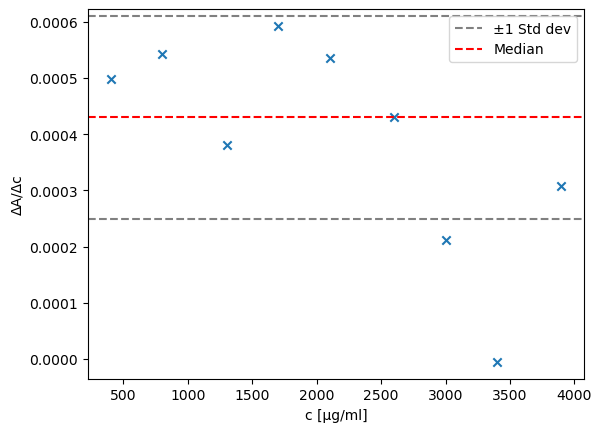

In [50]:
from plotting_util import scatter_plot_with_statistics
scatter_plot_with_statistics(pairwise_slopes_da, x_coord='c', location=('median', median_slope), scale=('std dev', std_slope))

In [57]:
# Extract the linear range by removing the last three points
linear_slopes_da = pairwise_slopes_da[:-3]
linear_slopes_da

<xarray.DataArray (idx: 6)>
array([0.0004975, 0.0005425, 0.00038  , 0.0005925, 0.000535 , 0.00043  ])
Coordinates:
  * idx      (idx) float64 14.0 18.0 23.0 27.0 31.0 36.0
    c        (idx) float64 400.0 800.0 1.3e+03 1.7e+03 2.1e+03 2.6e+03
Attributes:
    long_name:  ΔA/Δc

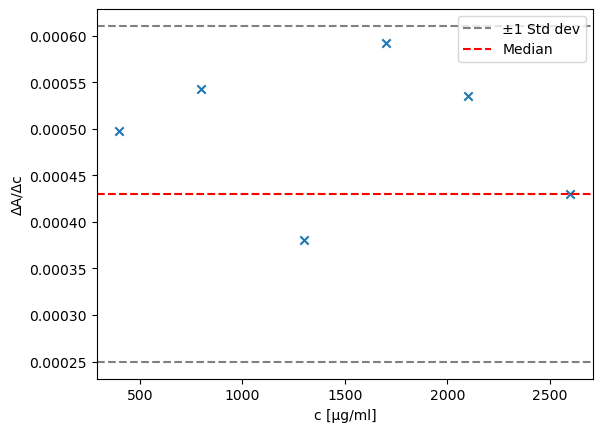

In [58]:
scatter_plot_with_statistics(linear_slopes_da, x_coord='c', location=('median', median_slope), scale=('std dev', std_slope))

## 2. Calculate Calibration Curve
To calculate the calibration curve we will run a **linear regression** on the linear range.

In [77]:
from sklearn.linear_model import LinearRegression

X = ref_points_da['c'][:-3].values.reshape(-1, 1)
y = ref_points_da[:-3].values

# Fit the model
model = LinearRegression()
model.fit(X, y)
print(f"Slope (a): {model.coef_[0]:.5f}")
print(f"Intercept (b): {model.intercept_:.5f}")

Slope (a): 0.00049
Intercept (b): -0.00286


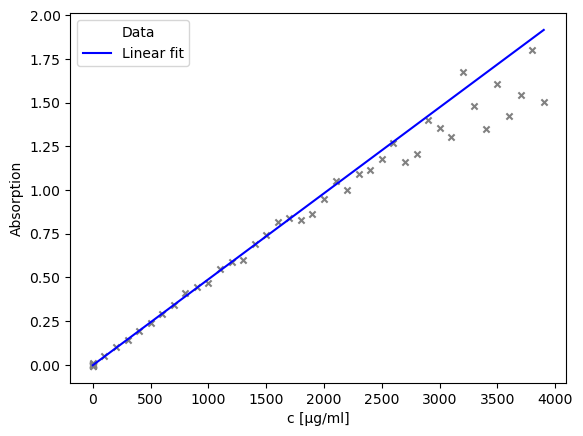

In [79]:
# Predict absorption and plot linear fit
X_all = protein_da['c'].values.reshape(-1, 1)
absorption_pred = model.predict(X_all)
line_plot_with_marks(protein_da, x_coord='c', display=False, label='Data', linestyle='', marker='x')
plt.plot(X_all, absorption_pred, c='blue', label='Linear fit')
plt.ylabel('Absorption')
plt.legend()
plt.show()


## LOD and LOQ of Calibration Curve
To calculate the **limit of detection** $LOD=3.3\frac{s}{a}$ and **limit of quantification** $LOQ=10\frac{s}{a}$ we need to compute the 
standard deviation of the blank sample, denoted by $s$, and get the slope of the calibration $a$. In our data, the first ten measurements (at 
concentration
 0.0) 
constitute the blank sample.

In [82]:
blank_sample_da = protein_da[:10]
blank_sample_da

<xarray.DataArray (idx: 10)>
array([-0.007, -0.001,  0.005, -0.003, -0.007,  0.008,  0.003, -0.   ,
        0.001,  0.   ])
Coordinates:
  * idx      (idx) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0
    c        (idx) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

In [83]:
s = blank_sample_da.std()
a = model.coef_[0]
lod = 3.3 * s / a
loq = 10 * s / a
print(f"LOD: {lod:.5f}")
print(f"LOQ: {loq:.5f}")

LOD: 30.51446
LOQ: 92.46806


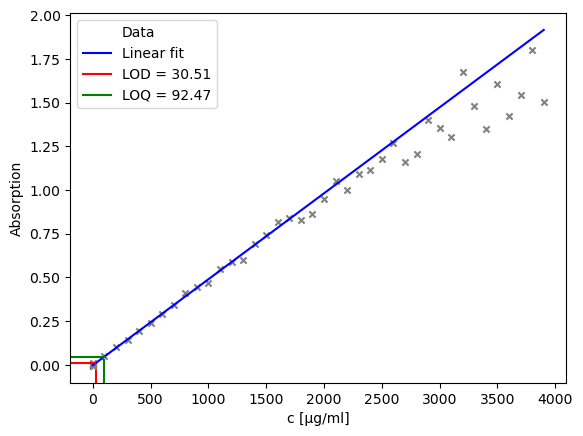

In [109]:
lod_absorption = model.predict(np.array([[lod]]))[0]
loq_absorption = model.predict(np.array([[loq]]))[0]

line_plot_with_marks(protein_da, x_coord='c', display=False, label='Data', linestyle='', marker='x')
plt.plot(X_all, absorption_pred, c='blue', label='Linear fit')

# Add lines for LOD and LOQ, limited to the linear fit
plt.axvline(lod, color='red', ymax=lod_absorption + 0.02, label=f'LOD = {lod:.2f}')
plt.axvline(loq, color='green', ymax=loq_absorption + 0.02, label=f'LOQ = {loq:.2f}')
plt.axhline(lod_absorption, color='red', xmax=0.05)
plt.axhline(loq_absorption, color='green', xmax=0.07)

plt.ylabel('Absorption')
plt.legend()
plt.show()